In [1]:
'''
주어진 이미지가 거북목 자세인지 아닌지 판단하는 ResNet18 모델 구현.
커스텀한 데이터셋 사용.
'''

''' 장비 준비 '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torchvision.models as models


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('using pytorch version : ',torch.__version__, '   device : ',DEVICE)


''' 필요한 값 설정 '''
seed = 777
random.seed(seed)
torch.manual_seed(seed)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(seed)
    
BATCH_SIZE = 100
EPOCHS = 42

# 하이퍼파라미터 설정
learning_rate = 0.0015
momentum = 0
weight_decay = 1e-4


''' 데이터셋 준비 '''
path = './dataset' # 불러올 데이터셋 경로

# 폴더 안의 이미지 데이터 불러오기
dataset = datasets.ImageFolder(root = path,
                              transform = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.4, 0.4, 0.4], [0.2, 0.2, 0.2])
                              ])) 

# train/test data 분리. 사이킷런 train_test_split과 torch.utils.data의 Subset 활용
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size = 0.1, random_state = seed)
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

# 학습/평가용 데이터 생성 완료
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)


''' pretrained 된 모델/optimizer/loss function 정의하기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

## 모델 확인
model = model.to(DEVICE)
summary(model, input_size=(3,224,224)) # (channels, H, W)


''' train/test 수행 과정 구현 '''
# train
train_loss_list = [] # 에폭별 평균 loss 값 저장할 리스트
def train(model, train_loader, optimizer, log_interval) :
    average_cost = 0 # 각 에폭별 평균 loss 구하기
    model.train()
    print('================== T R A I N I N G . . . ==================')
    print("                        EPOCH {}                  ".format(epoch))
    for idx, (img,label) in enumerate(train_loader) :
        num_of_mini_batch = len(train_loader)
        img = img.to(DEVICE)
        label = label - 1 # GPU 환경에서만 적용
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_function(output,label)
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item()/num_of_mini_batch) # 에폭마다 평균 loss를 구하기 위한 과정
        # loss.item()은 loss가 연산가능하게끔 torch.Tensor 형에서 float로 바꾸어줌
        
        # 결과 출력
        if idx % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(idx*BATCH_SIZE, 
                                                               len(train_loader.dataset),
                                                               100.*idx / num_of_mini_batch,
                                                               loss.item()))
    train_loss_list.append(average_cost)
    print('============================================================')
    
# test
test_loss_list = [] # 각 에폭별 test 데이터에 대한 평균 loss
test_accuracy_list = [] # 각 에폭별 test 데이터에 대한 accuracy 모을 리스트
def evaluate(model, test_loader):
    model.eval()
    num_of_mini_batch = len(test_loader)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label - 1 # GPU 환경에서만 적용
            label = label.to(DEVICE)
            output = model(image)
            # 각 배치별 평균 loss 값을 저장
            loss = loss_function(output,label)
            test_loss += loss.item()
            # 가장 큰 확률을 가진 클래스로 예측값 결정
            prediction = output.max(1, keepdim = True)[1]
            # 예측값과 실제값이 동일한 경우 카운트
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                
        test_loss /= num_of_mini_batch
        test_accuracy = 100. * correct / len(test_loader.dataset)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        return test_loss, test_accuracy  
    
    
''' 모델 학습 및 평가 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 6)
    test_loss, test_accuracy =  evaluate(model, test_loader)
    print("\nTest Epoch:{}\tTest Loss:{:.4f}\tTest Accracy:{:.2f}% \n ".format(epoch,test_loss,test_accuracy))

using pytorch version :  1.7.0+cu101    device :  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56] 


Test Epoch:7	Test Loss:0.3118	Test Accracy:85.75% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 8                  
[0/3600](0%)   Train Loss : 0.236833 
[600/3600](17%)   Train Loss : 0.269028 
[1200/3600](33%)   Train Loss : 0.269405 
[1800/3600](50%)   Train Loss : 0.217646 
[2400/3600](67%)   Train Loss : 0.282622 
[3000/3600](83%)   Train Loss : 0.301224 

Test Epoch:8	Test Loss:0.3017	Test Accracy:86.75% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 9                  
[0/3600](0%)   Train Loss : 0.185970 
[600/3600](17%)   Train Loss : 0.283156 
[1200/3600](33%)   Train Loss : 0.268140 
[1800/3600](50%)   Train Loss : 0.284549 
[2400/3600](67%)   Train Loss : 0.270076 
[3000/3600](83%)   Train Loss : 0.275260 

Test Epoch:9	Test Loss:0.2919	Test Accracy:88.25% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 10                  
[0/3600](0%) 

[0/3600](0%)   Train Loss : 0.137708 
[600/3600](17%)   Train Loss : 0.114961 
[1200/3600](33%)   Train Loss : 0.142927 
[1800/3600](50%)   Train Loss : 0.180960 
[2400/3600](67%)   Train Loss : 0.134707 
[3000/3600](83%)   Train Loss : 0.214895 

Test Epoch:25	Test Loss:0.2299	Test Accracy:90.75% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 26                  
[0/3600](0%)   Train Loss : 0.098254 
[600/3600](17%)   Train Loss : 0.190932 
[1200/3600](33%)   Train Loss : 0.141518 
[1800/3600](50%)   Train Loss : 0.153882 
[2400/3600](67%)   Train Loss : 0.112514 
[3000/3600](83%)   Train Loss : 0.175134 

Test Epoch:26	Test Loss:0.2282	Test Accracy:91.00% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 27                  
[0/3600](0%)   Train Loss : 0.128486 
[600/3600](17%)   Train Loss : 0.142806 
[1200/3600](33%)   Train Loss : 0.112861 
[1800/3600](50%)   Train Loss : 0.135583 
[2400/3600]

[2400/3600](67%)   Train Loss : 0.057743 
[3000/3600](83%)   Train Loss : 0.071682 

Test Epoch:42	Test Loss:0.2296	Test Accracy:92.75% 
 


<Figure size 1000x500 with 2 Axes>

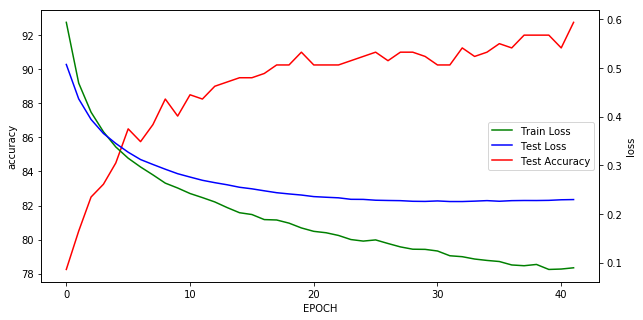

In [2]:
''' plotting '''
# 빨간선 : test accuracy
# 파란선 : test loss
# 초록선 : train loss
fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
g1 = ax2.plot(train_loss_list, color = 'green', label = 'Train Loss')
g2 = ax2.plot(test_loss_list, color = 'blue', label = 'Test Loss')
g3 = ax.plot(test_accuracy_list, color = 'red', label = 'Test Accuracy')

ax2.set_ylabel('loss')
ax.set_ylabel('accuracy')
ax.set_xlabel('EPOCH')

g = g1 + g2 + g3
labels = [l.get_label() for l in g]
ax.legend(g,labels, loc = 'right')
plt.show()